In [6]:
pip install numpy pandas scikit-learn tensorflow matplotlib


Note: you may need to restart the kernel to use updated packages.


In [11]:
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt


In [12]:
# Load the dataset
df = pd.read_csv('creditcard.csv')
# Drop the 'Time' column as it may not be relevant for anomaly detection
df = df.drop(['Time'], axis=1)

# Standardize the features
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['Class'] = df['Class'].astype(str) # Convert Class column to string for one-hot encoding

# Create one-hot encoding for the 'Class' column
df = pd.get_dummies(df, columns=['Class'], prefix=['Class'])

# Split the dataset into train and test sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Extract features (X) and labels (y) for training and testing
X_train = train_data.drop(['Class_0', 'Class_1'], axis=1).values
y_train = train_data[['Class_0', 'Class_1']].values

X_test = test_data.drop(['Class_0', 'Class_1'], axis=1).values
y_test = test_data[['Class_0', 'Class_1']].values

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Load your X_train and X_test data (assuming it's already prepared)
# ... code to load X_train and X_test

# Define the autoencoder model function
def build_autoencoder(input_shape):
  model = models.Sequential()
  # Encoder layer part
  model.add(layers.InputLayer(input_shape=(input_shape,)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(16, activation='relu'))  # bottleneck layer
  # Decoder layer part
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(input_shape, activation='tanh'))
  return model

# Create the autoencoder model
input_shape = X_train.shape[1]  # Assuming X_train is already loaded
autoencoder = build_autoencoder(input_shape)

# Compile the model
autoencoder.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])

# Train the model
history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=64, shuffle=False, validation_data=(X_test, X_test))


Epoch 1/10
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.5385 - loss: 0.6177 - val_accuracy: 0.6758 - val_loss: 0.4857
Epoch 2/10
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7106 - loss: 0.4598 - val_accuracy: 0.7250 - val_loss: 0.4598
Epoch 3/10
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7384 - loss: 0.4462 - val_accuracy: 0.7029 - val_loss: 0.4554
Epoch 4/10
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7387 - loss: 0.4410 - val_accuracy: 0.7043 - val_loss: 0.4501
Epoch 5/10
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7411 - loss: 0.4380 - val_accuracy: 0.7157 - val_loss: 0.4449
Epoch 6/10
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7426 - loss: 0.4360 - val_accuracy: 0.7161 - val_loss: 0.4391
Epoch 7/10
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7460 - loss: 0.4344 - val_accuracy: 0.7276 - val_loss: 0.4367
Epoch 8/10
3561/3561 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7486 - loss: 0.4332 - 

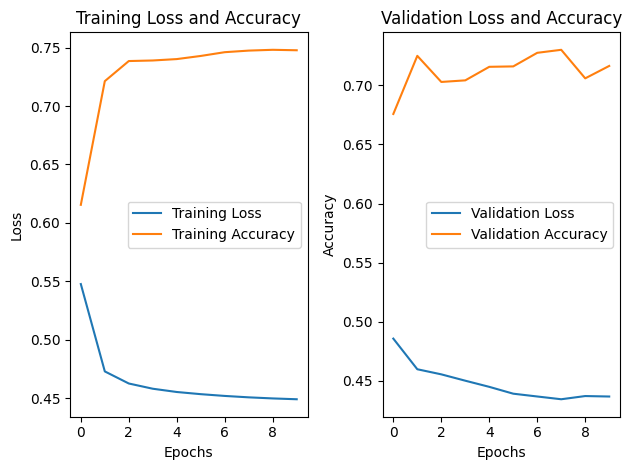

In [17]:
# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Validation Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
# Evaluate the Autoencoder
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)

# Set a threshold for anomaly detection
threshold = 0.6 # You may need to adjust this threshold based on experimentation

# Classify anomalies based on the threshold
anomalies = mse > threshold

# Evaluate the Anomaly Detection Model
y_true = np.argmax(y_test, axis=1)
y_pred = anomalies.astype(int)

accuracy = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step
Test Accuracy: 0.9222


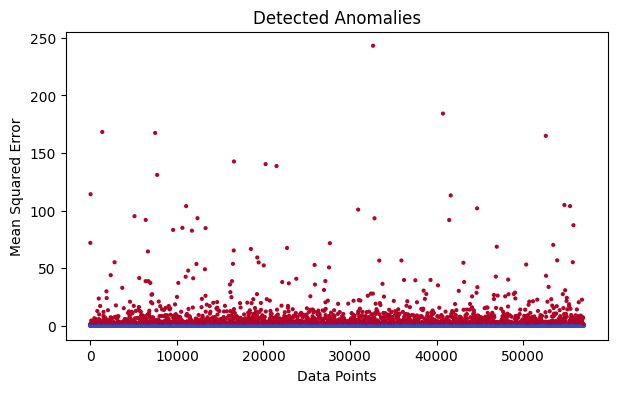

In [19]:
# Scatter plot for Anomalies
plt.figure(figsize=(7, 4))
plt.scatter(range(len(mse)), mse, c=anomalies, cmap='coolwarm', s=4)
plt.title('Detected Anomalies')
plt.xlabel('Data Points')
plt.ylabel('Mean Squared Error')
plt.show()


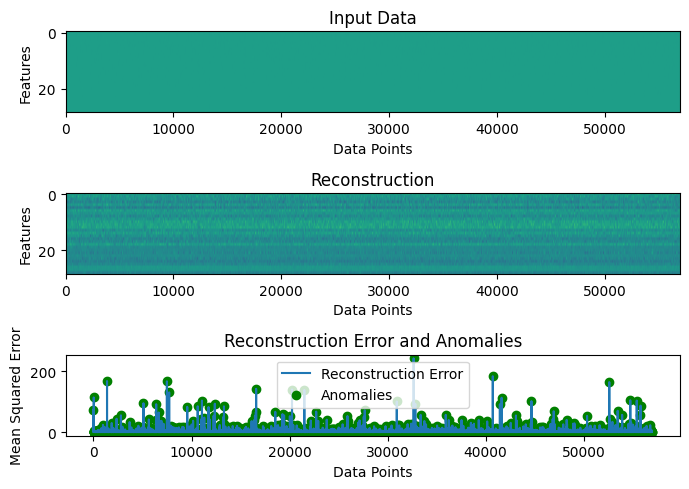

In [21]:
# Visualize Input, Reconstruction and Error
plt.figure(figsize=(7, 5))

# Plot Input Data
plt.subplot(3, 1, 1)
plt.imshow(X_test.T, aspect='auto', cmap='viridis')
plt.title('Input Data')
plt.xlabel('Data Points')
plt.ylabel('Features')

# Plot Reconstruction
plt.subplot(3, 1, 2)
plt.imshow(predictions.T, aspect='auto', cmap='viridis')
plt.title('Reconstruction')
plt.xlabel('Data Points')
plt.ylabel('Features')

# Plot Reconstruction Error
plt.subplot(3, 1, 3)
plt.plot(mse, label='Reconstruction Error')
plt.scatter(np.where(anomalies)[0], mse[anomalies], color='green', label='Anomalies')
plt.title('Reconstruction Error and Anomalies')
plt.xlabel('Data Points')
plt.ylabel('Mean Squared Error')
plt.legend()

plt.tight_layout()
plt.show()



In [2]:
import cv2

In [3]:
# url="http://192.168.8.156:4747/video", you can also intigrate your web cam with this by giving tha url in 0 position 
cap = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Display the resulting frame
    if ret:
        # Display the resulting frame
        cv2.imshow("out",frame)
    else:
          break


    # Exit the loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break

# Release the capture
cap.release()
cv2.destroyAllWindows()